<a href="https://colab.research.google.com/github/dduwa/ocular-disease-recognition/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [ ]:
!pip install tensorflow_addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

import tensorflow as tf
import tensorflow_addons as tfa

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


from random import sample
from random import shuffle
from sklearn.preprocessing import MultiLabelBinarizer


print(tf.__version__)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


2.15.0


#Access Dataset via Kaggle API
- Within the Dataset, patient age and sex is provided with diagnosis for both the left and right eye being given. One hot encoding is used for the ocular conditions, each condition is represented by its own column where for each image a binary value of 1 or 0 is given to indicate the absence of presence of a disease. The labels coloumn includes the actual diagnosis label for the patient with the target column providing a binary vector representation of the conditions aligning with the individual conditions problem.

In [ ]:
from google.colab import files
uploaded = files.upload()

!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
!unzip -q ocular-disease-recognition-odir5k.zip

Saving kaggle.json to kaggle.json
100% 1.62G/1.62G [00:48<00:00, 40.8MB/s]
100% 1.62G/1.62G [00:48<00:00, 35.6MB/s]


# Visualising the Data

In [ ]:
df_data = pd.read_csv('full_df.csv')
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [ ]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

Distribution of Classes

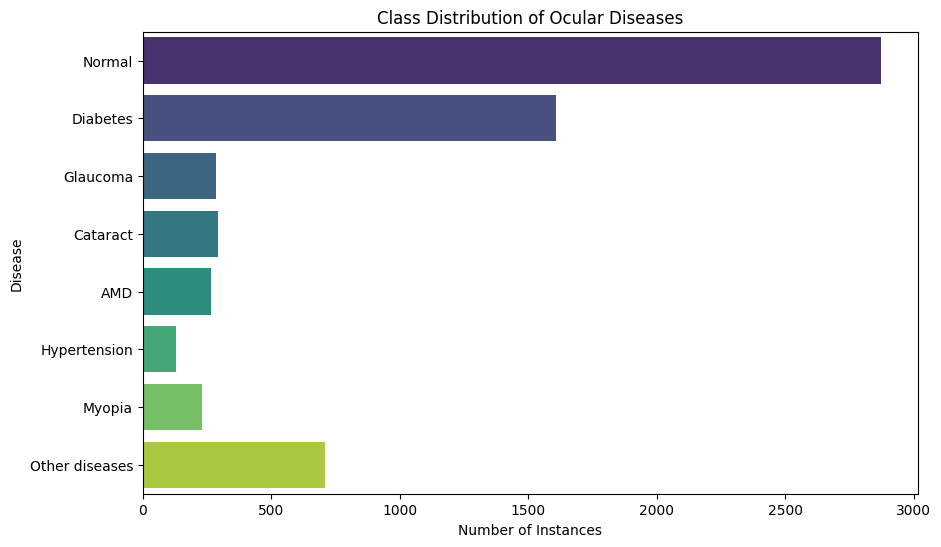

In [ ]:
import ast
# Define the class labels as provided by the user
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Decode one-hot encoded labels to class names
df_data['class_name'] = df_data['target'].apply(lambda x: class_labels[ast.literal_eval(x).index(1)])


# Now we create a Series with the counts of each class name
class_counts = df_data['class_name'].value_counts().reindex(class_labels).fillna(0)

# Plot the class distribution using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.values, y=class_counts.index, hue=class_counts.index, palette="viridis", legend=False)
plt.title('Class Distribution of Ocular Diseases')
plt.xlabel('Number of Instances')
plt.ylabel('Disease')
plt.show()


#Data Preparation
- Extracting Disease Specific Keywords using Left Diagnositic Keyword and Right Diagnostic Keyword Columns

Keyword Preparation

In [ ]:
leftEyeKeywords = df_data['Left-Diagnostic Keywords'].copy()
rightEyeKeywords = df_data['Right-Diagnostic Keywords'].copy()

In [ ]:
leftEyeKeywords = leftEyeKeywords.str.split("，")
rightEyeKeywords = rightEyeKeywords.str.split("，")

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

res = pd.DataFrame(mlb.fit_transform(rightEyeKeywords),
                   columns=mlb.classes_,
                   index=rightEyeKeywords.index)

allDiagnosisLeft = res.columns.to_list()
len(allDiagnosisLeft)

res = pd.DataFrame(mlb.fit_transform(leftEyeKeywords),
                   columns=mlb.classes_,
                   index=leftEyeKeywords.index)

allDiagnosisRight = res.columns.to_list()
len(allDiagnosisRight)

allDiagnosis=list(set(allDiagnosisLeft+allDiagnosisRight))
print("total different keys diagnosis :", len(allDiagnosis))

total different keys diagnosis : 96


Extracting Keywords for Single-Diagnosis Rows

In [ ]:
test_df = df_data.copy()
doubleDiagnosisRow = []

def getKeyDiagnosisSingle(colName):
  keyDiagnosis = []
  global doubleDiagnosisRow
  store = True
  for row in range(len(test_df[colName])):
    store = True
    if test_df[colName][row] == 1:
      for lable in test_df.columns[7:]:
        if lable == colName:
          continue
        if test_df[lable][row] == 1:
          doubleDiagnosisRow.append(row)
          store = False
          break

      if store == True:
        for i in rightEyeKeywords[row]:
          keyDiagnosis.append(i)
        for i in leftEyeKeywords[row]:
          keyDiagnosis.append(i)


  keyDiagnosis = list(set(keyDiagnosis))
  return keyDiagnosis

keyNormal = getKeyDiagnosisSingle(test_df.columns[7])
keyDiabetes = getKeyDiagnosisSingle(test_df.columns[8])
keyGlaucoma = getKeyDiagnosisSingle(test_df.columns[9])
keyCataract = getKeyDiagnosisSingle(test_df.columns[10])
keyAMD = getKeyDiagnosisSingle(test_df.columns[11])
keyHypertension = getKeyDiagnosisSingle(test_df.columns[12])
keyMyopia = getKeyDiagnosisSingle(test_df.columns[13])
keyOtherDisease = getKeyDiagnosisSingle(test_df.columns[14])

labelString = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Abnormalities']
keyAll = [keyNormal, keyDiabetes, keyGlaucoma, keyCataract, keyAMD, keyHypertension, keyMyopia, keyOtherDisease]

for i in range(8):
  print(labelString[i], len(keyAll[i]))

Normal 3
Diabetes 10
Glaucoma 5
Cataract 3
AMD 3
Hypertension 1
Myopia 5
Abnormalities 50


In [ ]:
n_count = len(keyNormal)
d_count = len(keyDiabetes)
g_count = len(keyGlaucoma)
c_count = len(keyCataract)
amd_count = len(keyAMD)
h_count = len(keyHypertension)
m_count = len(keyMyopia)
o_count = len(keyOtherDisease)

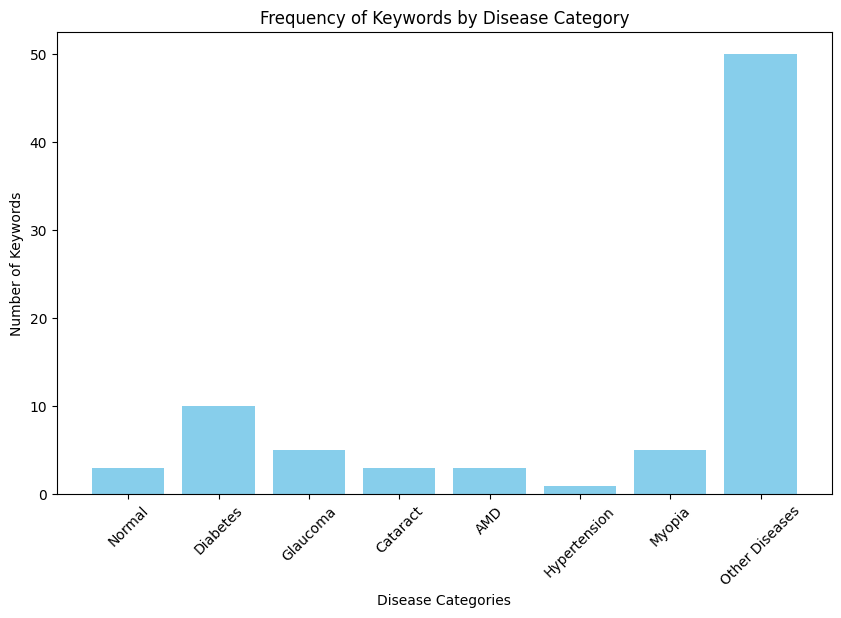

In [ ]:
# Categories and their respective keyword counts
categories = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other Diseases']
keyword_counts = [n_count, d_count, g_count, c_count, amd_count, h_count, m_count,o_count]

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.bar(categories, keyword_counts, color='skyblue')
plt.xlabel('Disease Categories')
plt.ylabel('Number of Keywords')
plt.title('Frequency of Keywords by Disease Category')
plt.xticks(rotation=45)
plt.show()

Keyword Deduplication Across Diagnoses

- To ensure uniqueness by removing any keyword that appears in multiple categories.


In [ ]:
print("intersect by normal :\n")
for i in range(1,len(keyAll)):
  keyAll[i] = list(set(keyAll[i])-set(keyAll[0]))

for i in range(8):
  print(labelString[i], len(keyAll[i]))

print("\nintersect by other :\n")
for i in range(len(keyAll)):
  for j in range(i,len(keyAll)):
    if i == j:
      continue
    else :
      keyAll[i] = list(set(keyAll[i])-set(keyAll[j]))

for i in range(8):
  print(labelString[i], len(keyAll[i]))

intersect by normal :

Normal 3
Diabetes 8
Glaucoma 3
Cataract 1
AMD 2
Hypertension 1
Myopia 3
Abnormalities 47

intersect by other :

Normal 3
Diabetes 7
Glaucoma 3
Cataract 1
AMD 2
Hypertension 1
Myopia 3
Abnormalities 47


In [ ]:
def getAllRecognizedKey(mkeyAll):
  mallkeyDiagnosis = []
  for i in range(len(mkeyAll)):
    mkeyAll[i] = list(set(mkeyAll[i]))
    mallkeyDiagnosis = mallkeyDiagnosis+list(set(mkeyAll[i]))
  return mallkeyDiagnosis

In [ ]:
keyNormal, keyDiabetes, keyGlaucoma, keyCataract, keyAMD, keyHypertension, keyMyopia, keyOtherDisease = keyAll[0], keyAll[1], keyAll[2], keyAll[3], keyAll[4], keyAll[5], keyAll[6], keyAll[7]

allkeyDiagnosis = getAllRecognizedKey(keyAll)
len(allkeyDiagnosis)

67

In [ ]:
doubleDiagnosisRow = list(set(doubleDiagnosisRow))
print("double label row ",len(doubleDiagnosisRow))
doubleDiagnosisRow.sort()
# doubleDiagnosisRow

double label row  1001


In [ ]:
notlisted = []
listed = False
for row in doubleDiagnosisRow:
  # print(row)
  for ilist in leftEyeKeywords[row]:
    # print(ilist)
    listed = False
    for j in keyAll:
      if ilist in j:
        listed = True
        break
    if listed == False:
      notlisted.append(ilist)

for row in doubleDiagnosisRow:
  for ilist in rightEyeKeywords[row]:
    listed = False
    for j in keyAll:
      if ilist in j:
        listed = True
        break
    if listed == False:
      notlisted.append(ilist)

notlisted = list(set(notlisted))
# notlisted
print("not listed diagnosis key :",len(notlisted))

not listed diagnosis key : 29


In [ ]:
def intersectFromMultiLabel(mkeyAll):
  mnotRecognizedList = []
  mallkeyDiagnosis = []
  for i in range(len(mkeyAll)):
    mkeyAll[i] = list(set(mkeyAll[i]))
    mallkeyDiagnosis = mallkeyDiagnosis+list(set(mkeyAll[i]))
  for row in doubleDiagnosisRow:
    notlistedList = []
    listedList = []
    colIndex = []
    ind = []
    tempList = []
    for ilist in leftEyeKeywords[row]:
      if ilist not in mallkeyDiagnosis:
        tempList.append(ilist)
    for ilist in rightEyeKeywords[row]:
      if ilist not in mallkeyDiagnosis:
        tempList.append(ilist)

    for i in range(7, len(test_df.columns)):
      if test_df[test_df.columns[i]][row] == 1:
        colIndex.append(i-7)
    tempList = list(set(tempList))
    isContainAbnormal = 7 in colIndex
    if len(tempList) > 0:
      ind = colIndex
      for ilist in leftEyeKeywords[row]:
        if ilist not in tempList:
          listedList.append(ilist)
      for ilist in rightEyeKeywords[row]:
        if ilist not in tempList:
          listedList.append(ilist)

      for ilist in listedList:
        for i in colIndex:
          if ilist in keyNormal:
            continue
          if ilist in mkeyAll[i]:
            ind.remove(i)

      if len(ind) == 0 and isContainAbnormal:
        ind.append(7)
      if len(ind) == 1 and len(tempList) == 1:
        mkeyAll[ind[0]] = mkeyAll[ind[0]] + tempList
        mkeyAll[ind[0]] = list(set(mkeyAll[ind[0]]))
      else:
        print("not recognize")
        mnotRecognizedList.append(tempList[0])
        mnotRecognizedList = list(set(mnotRecognizedList))

    mallkeyDiagnosis = []
    for i in mkeyAll:
      mallkeyDiagnosis = mallkeyDiagnosis+list(set(i))
  return mkeyAll, mnotRecognizedList

In [ ]:
itterate = True
notRecognizedList = []
while itterate :
  temp_allkeyDiagnosis = allkeyDiagnosis.copy()
  keyAll, notRecognizedList = intersectFromMultiLabel(keyAll)
  allkeyDiagnosis = getAllRecognizedKey(keyAll)
  # print(len(temp_allkeyDiagnosis), len(allkeyDiagnosis))
  print(notRecognizedList)
  if len(temp_allkeyDiagnosis) == len(allkeyDiagnosis):
    print(True)
    itterate = False

not recognize
not recognize
not recognize
not recognize
['suspected cataract', 'pigmentation disorder', 'image offset']
not recognize
not recognize
not recognize
not recognize
['suspected cataract', 'pigmentation disorder', 'image offset']
True


In [ ]:
allkeyDiagnosis = getAllRecognizedKey(keyAll)

keyNormal, keyDiabetes, keyGlaucoma, keyCataract, keyAMD, keyHypertension, keyMyopia, keyOtherDisease = keyAll[0], keyAll[1], keyAll[2], keyAll[3], keyAll[4], keyAll[5], keyAll[6], keyAll[7]

for i in range(8):
  print(labelString[i], len(keyAll[i]))

print("\nall regnized key :",len(allkeyDiagnosis))
print("\nnot recognized key : ", list(set(allDiagnosis)-set(allkeyDiagnosis)))

Normal 3
Diabetes 11
Glaucoma 3
Cataract 1
AMD 3
Hypertension 1
Myopia 4
Abnormalities 66

all regnized key : 92

not recognized key :  ['suspected cataract', 'image offset', 'pigmentation disorder', 'macular pigmentation disorder']


In [ ]:
#manual listed key
string = 'suspected cataract'
if string in notRecognizedList and string not in allkeyDiagnosis:
  keyAll[3].append(string)
  notRecognizedList.remove(string)

In [ ]:
keyAll[3]

['cataract', 'suspected cataract']

In [ ]:
allkeyDiagnosis = getAllRecognizedKey(keyAll)

keyNormal, keyDiabetes, keyGlaucoma, keyCataract, keyAMD, keyHypertension, keyMyopia, keyOtherDisease = keyAll[0], keyAll[1], keyAll[2], keyAll[3], keyAll[4], keyAll[5], keyAll[6], keyAll[7]

for i in range(len(keyAll)):
  print(labelString[i], len(keyAll[i]))

print("\nall regnized key :",len(allkeyDiagnosis))
print("\nnot recognized key : ", list(set(allDiagnosis)-set(allkeyDiagnosis)))

Normal 3
Diabetes 11
Glaucoma 3
Cataract 2
AMD 3
Hypertension 1
Myopia 4
Abnormalities 66

all regnized key : 93

not recognized key :  ['image offset', 'pigmentation disorder', 'macular pigmentation disorder']


In [ ]:
string = 'central serous chorioretinopathy'

for i in notRecognizedList:
  if i not in allkeyDiagnosis:
    print("not in : ", i)

string in keyOtherDisease

not in :  pigmentation disorder
not in :  image offset


True

#Organising the train, test and validation data into directories

In [ ]:
import os
import shutil
from random import shuffle
training_source_path = 'ODIR-5K/ODIR-5K/Training Images/'

diagnosis_mapping = {
    'Normal': keyNormal,
    'Diabetes': keyDiabetes,
    'Glaucoma': keyGlaucoma,
    'Cataract': keyCataract,
    'AMD': keyAMD,
    'Hypertension': keyHypertension,
    'Myopia': keyMyopia,
    'Other Diseases': keyOtherDisease,
}

In [ ]:

def setup_dir(path):
    """Create or reset a directory."""
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)  # makedirs() creates intermediate directories as needed

# Base directory paths
base_dir = 'Split_Data/'
train_dir = os.path.join(base_dir, 'training/')
validation_dir = os.path.join(base_dir, 'validation/')
test_dir = os.path.join(base_dir, 'testing/')

# Resetting or creating the main directories
setup_dir(base_dir)
setup_dir(train_dir)
setup_dir(validation_dir)
setup_dir(test_dir)

# Category names
labelString = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other Diseases']

# Create subdirectories in training, validation, and testing directories
for category in labelString:
    setup_dir(os.path.join(train_dir, category))
    setup_dir(os.path.join(validation_dir, category))
    setup_dir(os.path.join(test_dir, category))

# Assuming training_source_path is predefined
training_source_files = os.listdir(training_source_path)

# Shuffle the training source files to ensure randomness
shuffle(training_source_files)

# Set the fractions for the validation and test sets
validation_fraction = 0.1
test_fraction = 0.1

# Calculate the number of files for validation and testing
nvalidation = int(len(training_source_files) * validation_fraction)
ntesting = int(len(training_source_files) * test_fraction)
ntraining = len(training_source_files) - nvalidation - ntesting

# Split the files into training, validation, and testing using slicing
validation_files = training_source_files[:nvalidation]
test_files = training_source_files[nvalidation:nvalidation+ntesting]
training_files = training_source_files[nvalidation+ntesting:]

# Function to categorize files based on diagnosis keywords
def categorize_files(file_list, source_path, target_dir):
    not_sorted_files = set()  # Using a set to automatically avoid duplicates

    for fileName in file_list:
        nrow = None
        if 'left' in fileName:
            temp_df = df_data['Left-Fundus']
            temp_keywords = leftEyeKeywords
        elif 'right' in fileName:
            temp_df = df_data['Right-Fundus']
            temp_keywords = rightEyeKeywords

        if temp_df is not None:
            for row in range(len(temp_df)):
                if fileName == temp_df[row]:
                    nrow = row
                    break

        if nrow is None:
            not_sorted_files.add(fileName)
            continue

        file_categorized = False
        for keyword in temp_keywords[nrow]:
            for diagnosis, keywords in diagnosis_mapping.items():
                if keyword in keywords:
                    try:
                        shutil.copyfile(
                            os.path.join(source_path, fileName),
                            os.path.join(target_dir, diagnosis, fileName)
                        )
                        file_categorized = True
                        break  # Remove this if a file can belong to multiple categories
                    except Exception as e:
                        print(f"Error copying file {fileName} to {diagnosis}: {e}")

        if not file_categorized:
            not_sorted_files.add(fileName)

    # Print summary
    print(f"Total files not sorted: {len(not_sorted_files)}")
    for diagnosis in diagnosis_mapping:
        print(f"{diagnosis}: {len(os.listdir(os.path.join(target_dir, diagnosis)))} files")

# Categorize files for each set
categorize_files(training_files, training_source_path, train_dir)
categorize_files(validation_files, training_source_path, validation_dir)
categorize_files(test_files, training_source_path, test_dir)


Total files not sorted: 212
Normal: 2458 files
Diabetes: 1421 files
Glaucoma: 253 files
Cataract: 242 files
AMD: 225 files
Hypertension: 152 files
Myopia: 213 files
Other Diseases: 876 files
Total files not sorted: 38
Normal: 289 files
Diabetes: 179 files
Glaucoma: 30 files
Cataract: 41 files
AMD: 30 files
Hypertension: 20 files
Myopia: 25 files
Other Diseases: 98 files
Total files not sorted: 36
Normal: 314 files
Diabetes: 165 files
Glaucoma: 38 files
Cataract: 24 files
AMD: 24 files
Hypertension: 20 files
Myopia: 26 files
Other Diseases: 102 files


In [ ]:
dirList = os.listdir(train_dir)
countx = 0
for i in dirList:
  countx+=len(os.listdir(train_dir+i))

print(countx)

len(os.listdir(training_source_path))

5840


7000

Checking if categorisation worked by extracting an image

In [ ]:
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img

Original size: 2464x1632 from Split_Data/training/Cataract/2182_right.jpg


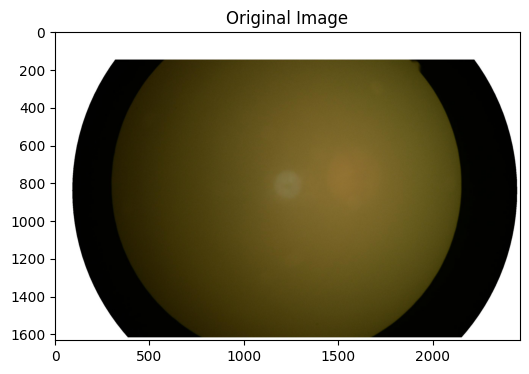

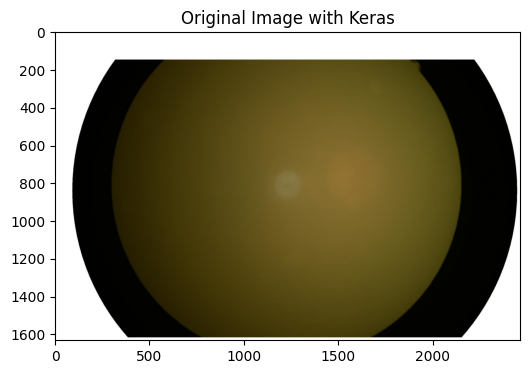

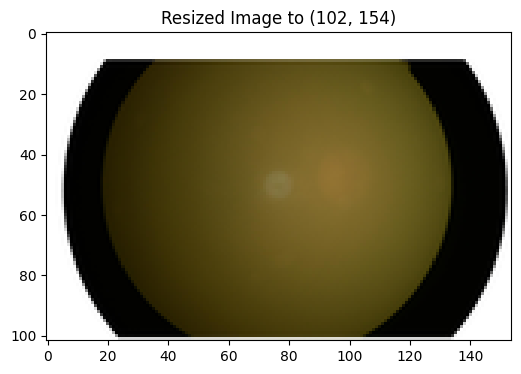

In [ ]:
cataractImageList = os.listdir(train_dir + 'Cataract')
imagePath = train_dir + 'Cataract/' + cataractImageList[2]

# Use PIL to open the image and get its dimensions
image = Image.open(imagePath)
width, height = image.size
print(f"Original size: {width}x{height} from {imagePath}")

# Display the original image with PIL
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title("Original Image")
plt.show()

# Display the original image with Keras load_img (for comparison, if needed)
plt.figure(figsize=(6, 6))
img = load_img(imagePath)
plt.imshow(img)
plt.title("Original Image with Keras")
plt.show()

# Display the resized image with Keras load_img
target_size = (int(height / 16), int(width / 16))
plt.figure(figsize=(6, 6))
img_resized = load_img(imagePath, target_size=target_size, interpolation="lanczos")
plt.imshow(img_resized)
plt.title(f"Resized Image to {target_size}")
plt.show()

# Making Data Generators

In [ ]:
# target_size = (int(height/16),int(width/16))
target_size = (224, 224)
# mode = 'grayscale'
color_mode = 'rgb'
if color_mode == 'grayscale':
  shapeadd = (1,)
if color_mode == 'rgb':
  shapeadd = (3,)

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
train_datagen = ImageDataGenerator(
                                  preprocessing_function=preprocess_input,  # Use VGG16 preprocessing
                                  zoom_range=0.2,
                                  rotation_range=40,
                                  # horizontal_flip=True,
                                  # width_shift_range=0.2,
                                  # height_shift_range=0.2,
                                  # shear_range=0.2,
                                  fill_mode='nearest',

                                  # featurewise_center=False,  # set input mean to 0 over the dataset
                                  # samplewise_center=False,  # set each sample mean to 0
                                  # featurewise_std_normalization=False,  # divide inputs by std of the dataset
                                  # samplewise_std_normalization=False,  # divide each input by its std
                                  # zca_whitening=False,  # apply ZCA whitening
                                  # vertical_flip=False
                                  )

validation_datagen = ImageDataGenerator(
                                        preprocessing_function=preprocess_input,  # Use VGG16 preprocessing
                                        )
# 32 default batch size is used.
train_generator = train_datagen.flow_from_directory(
	train_dir,
	target_size=target_size,
	class_mode='categorical',
  color_mode=color_mode,
)

validation_generator = validation_datagen.flow_from_directory(
	validation_dir,
	target_size=target_size,
	class_mode='categorical',
  color_mode=color_mode,
)

Found 5840 images belonging to 8 classes.
Found 712 images belonging to 8 classes.


#Training Model

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

nEpoch = 25
input_shape = (224, 224, 3)  # Adjust according to VGG16 requirements
learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Define metrics
kappa_score = tfa.metrics.CohenKappa(num_classes=8)
F1_score = tfa.metrics.F1Score(num_classes=8, average='macro')
AUC_value = tf.keras.metrics.AUC(num_thresholds=200, curve='ROC', multi_label=True)

print("Using pre-trained VGG16 model")
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False  # Freeze the base model

# Add custom layers on top
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(8, activation='softmax')  # Assuming 8 classes
])

model.summary()

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', kappa_score, F1_score, AUC_value]
)

Using pre-trained ResNet50 model
94765736/94765736 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                        

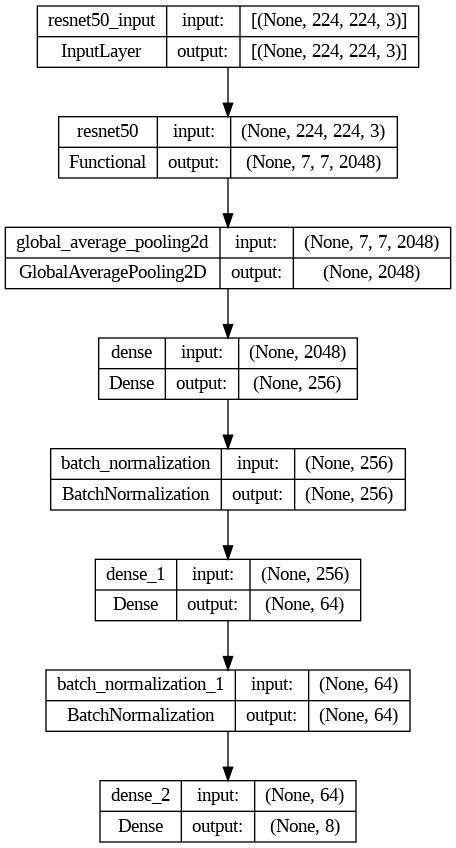

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
checkpoint_path = "/content/gdrive/My Drive/Trained_Models/ODIR5K/ODIR5K.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                #  save_weights_only=True,
                                                 verbose=1)

stopAccuracy = 0.900

# Define a Callback class that stops training once accuracy reaches the certain accuracy
class callbackStop(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>stopAccuracy):
      print("\nReached", stopAccuracy*100, " accuracy so cancelling training!")
      self.model.stop_training = True

callbackstop = callbackStop()

In [ ]:
history = model.fit(train_generator, validation_data=validation_generator,
                    epochs=150,
                    steps_per_epoch=50,
                    # batch_size=train_generator.batch_size,
                    # steps_per_epoch = train_generator.samples // train_generator.batch_size,
                    # validation_steps = validation_generator.samples // validation_generator.batch_size,
                    verbose=1,
                    callbacks=[
                               callbackstop,
                              #  cp_callback
                               ],
                    )

Epoch 1/150
50/50 [==============================] - 92s 2s/step - loss: 2.4271 - accuracy: 0.2071 - cohen_kappa: 0.0692 - f1_score: 0.1686 - auc: 0.5901 - val_loss: 2.3211 - val_accuracy: 0.1250 - val_cohen_kappa: 0.0335 - val_f1_score: 0.0968 - val_auc: 0.6539
Epoch 2/150
50/50 [==============================] - 74s 1s/step - loss: 2.1395 - accuracy: 0.2652 - cohen_kappa: 0.1046 - f1_score: 0.2070 - auc: 0.6478 - val_loss: 1.9596 - val_accuracy: 0.2346 - val_cohen_kappa: 0.0869 - val_f1_score: 0.2003 - val_auc: 0.6947
Epoch 3/150
50/50 [==============================] - 82s 2s/step - loss: 1.9891 - accuracy: 0.3350 - cohen_kappa: 0.1723 - f1_score: 0.2628 - auc: 0.6859 - val_loss: 1.7565 - val_accuracy: 0.3947 - val_cohen_kappa: 0.2161 - val_f1_score: 0.3246 - val_auc: 0.7269
Epoch 4/150
50/50 [==============================] - 72s 1s/step - loss: 1.8974 - accuracy: 0.3806 - cohen_kappa: 0.2146 - f1_score: 0.3046 - auc: 0.7262 - val_loss: 1.7226 - val_accuracy: 0.4438 - val_cohen_kap

In [ ]:
model_path = '/content/gdrive/My Drive/Trained_Models/ODIR5K-bottleneck/'
checkpoint_path = model_path+'ODIR5K.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

model_save_weights = 'weight'
model_save_name_h5 = 'ODIR5K.h5'
model_save_name_tf = 'ODIR5K_TF'
model.save_weights(model_path)
model.save_weights(model_path+model_save_weights)
model.save(model_path)
model.save(model_path+model_save_name_h5)
model.save(model_path+model_save_name_tf,save_format='tf')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Trained_Models/ODIR5K-bottleneck/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Trained_Models/ODIR5K-bottleneck/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Trained_Models/ODIR5K-bottleneck/ODIR5K_TF/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Trained_Models/ODIR5K-bottleneck/ODIR5K_TF/assets


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(model_path)
tflite_model = converter.convert()
open(model_path+"ODIR5K.tflite", "wb").write(tflite_model)

36227296

#Evaluating Model

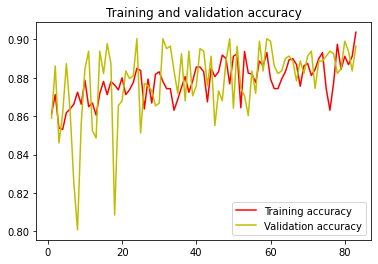

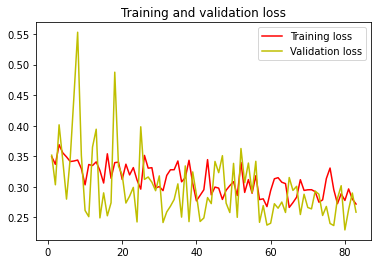

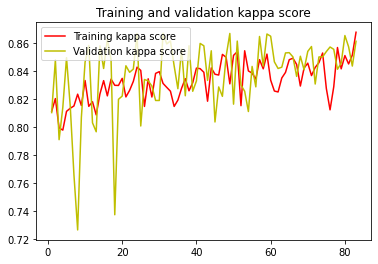

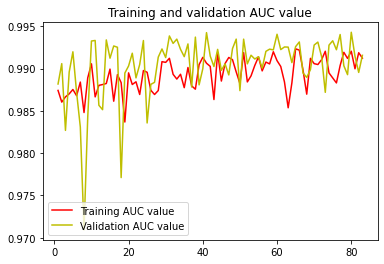

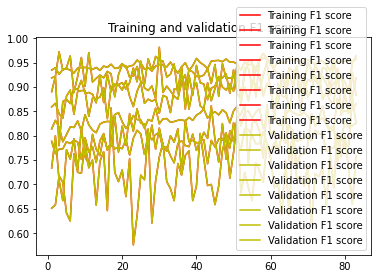

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

kappa = history.history['kappa score']
val_kappa = history.history['val_kappa score']

f1 = history.history['F-1 score']
val_f1 = history.history['F-1 score']

auc = history.history['auc']
val_auc = history.history['val_auc']

epochs_training = range(1, len(acc)+1)

plt.plot(epochs_training, acc, 'r', label='Training accuracy')
plt.plot(epochs_training, val_acc, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs_training, loss, 'r', label='Training loss')
plt.plot(epochs_training, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=1)
plt.figure()

plt.plot(epochs_training, kappa, 'r', label='Training kappa score')
plt.plot(epochs_training, val_kappa, 'y', label='Validation kappa score')
plt.title('Training and validation kappa score')
plt.legend(loc=2)
plt.figure()

plt.plot(epochs_training, auc, 'r', label='Training AUC value')
plt.plot(epochs_training, val_auc, 'y', label='Validation AUC value')
plt.title('Training and validation AUC value')
plt.legend(loc=3)
plt.figure()

plt.plot(epochs_training, f1, 'r', label='Training F1 score')
plt.plot(epochs_training, val_f1, 'y', label='Validation F1 score')
plt.title('Training and validation F1 score')
plt.legend(loc=4)
plt.figure()



plt.show()

In [ ]:
label_keys = list(train_generator.class_indices.keys())
label_values = list(train_generator.class_indices.values())

def getkey_indices(val):
  return label_keys[label_values.index(val)]

file : /tmp/ODIR-5K/testing/1000_left.jpg  | predicted as : Diabetes at : 3
file : /tmp/ODIR-5K/testing/1078_left.jpg  | predicted as : Myopia at : 6
file : /tmp/ODIR-5K/testing/1283_left.jpg  | predicted as : Myopia at : 6
file : /tmp/ODIR-5K/testing/1348_left.jpg  | predicted as : Myopia at : 6
file : /tmp/ODIR-5K/testing/1437_left.jpg  | predicted as : Myopia at : 6
file : /tmp/ODIR-5K/testing/1604_left.jpg  | predicted as : Myopia at : 6
file : /tmp/ODIR-5K/testing/1897_left.jpg  | predicted as : Cataract at : 2
file : /tmp/ODIR-5K/testing/1995_left.jpg  | predicted as : Myopia at : 6
file : /tmp/ODIR-5K/testing/2260_left.jpg  | predicted as : Myopia at : 6
file : /tmp/ODIR-5K/testing/3456_left.jpg  | predicted as : Myopia at : 6
file : /tmp/ODIR-5K/testing/3481_left.jpg  | predicted as : Glaucoma at : 4
file : /tmp/ODIR-5K/testing/3507_left.jpg  | predicted as : Myopia at : 6
file : /tmp/ODIR-5K/testing/3532_left.jpg  | predicted as : Myopia at : 6
file : /tmp/ODIR-5K/testing/3557

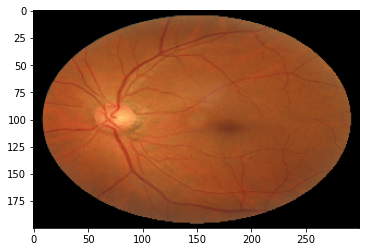

In [ ]:
testing_path =
testlist = os.listdir(testing_path)
testlist.sort()

for ifile in range(0,len(testlist),50):
  img = image.load_img(testing_path+testlist[ifile], target_size=target_size,)
  imgplot = plt.imshow(img)
  imgarray = image.img_to_array(img)
  imgarray = np.expand_dims(imgarray, axis=0)

  images = np.vstack([imgarray])
  classes = model.predict(images, batch_size=8)
  # probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
  # classes = probability_model.predict(images,batch_size=10)
  print("file :", testing_path+testlist[ifile]," | predicted as :", getkey_indices(np.argmax(classes)), "at :", np.argmax(classes))

file : /tmp/ODIR-5K/testing/1000_left.jpg  | predicted as : Diabetes at : 3 [[0.10289885 0.10289885 0.10289885 0.2797081  0.10289885 0.10289885
  0.10289885 0.10289885]]
file : /tmp/ODIR-5K/testing/1000_right.jpg  | predicted as : Diabetes at : 3 [[0.10289885 0.10289885 0.10289885 0.2797081  0.10289885 0.10289885
  0.10289885 0.10289885]]
file : /tmp/ODIR-5K/testing/1001_left.jpg  | predicted as : Glaucoma at : 4 [[0.10289885 0.10289885 0.10289885 0.10289885 0.2797081  0.10289885
  0.10289885 0.10289885]]
file : /tmp/ODIR-5K/testing/1001_right.jpg  | predicted as : Diabetes at : 3 [[0.10289885 0.10289885 0.10289885 0.2797081  0.10289885 0.10289885
  0.10289885 0.10289885]]
file : /tmp/ODIR-5K/testing/1002_left.jpg  | predicted as : Glaucoma at : 4 [[0.10289885 0.10289885 0.10289885 0.10289885 0.2797081  0.10289885
  0.10289885 0.10289885]]
file : /tmp/ODIR-5K/testing/1002_right.jpg  | predicted as : Myopia at : 6 [[0.10289885 0.10289885 0.10289885 0.10289885 0.10289885 0.10289885
  0.2

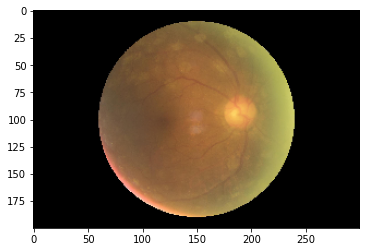

In [ ]:
testlist = os.listdir(testing_path)

testlist.sort()

for ifile in range(0,10):
  img = image.load_img(testing_path+testlist[ifile], target_size=target_size,)
  imgplot = plt.imshow(img)
  imgarray = image.img_to_array(img)
  imgarray = np.expand_dims(imgarray, axis=0)

  images = np.vstack([imgarray])
  classes = model.predict(images, batch_size=8)
  probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
  classes = probability_model.predict(images,batch_size=8)
  print("file :", testing_path+testlist[ifile]," | predicted as :", getkey_indices(np.argmax(classes)), "at :", np.argmax(classes), classes)

In [ ]:
model.evaluate_generator(validation_generator)

Instructions for updating:
Please use Model.evaluate, which supports generators.


Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.2582862079143524,
 0.8965071439743042,
 0.8615550994873047,
 array([0.94736844, 0.7949791 , 0.9387755 , 0.8592233 , 0.875     ,
        0.7826087 , 0.88524586, 0.96494156], dtype=float32),
 0.991568386554718]

# Making Predictions

In [ ]:
model.predict('/tmp/ODIR-5K/testing/1000_left.jpg')

IndexError: ignored

[6]
[[0.10289885 0.10289885 0.10289885 0.10289885 0.10289885 0.10289885
  0.2797081  0.10289885]]
file :  /tmp/ODIR-5K/testing/1897_left.jpg
predicted as :  6


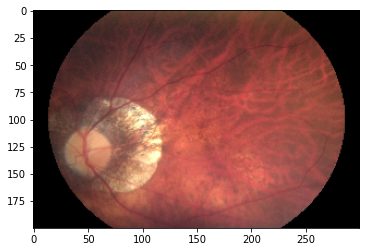

In [ ]:
# for ifile in testlist:
img = tf.keras.preprocessing.image.load_img('/tmp/ODIR-5K/testing/1604_left.jpg', target_size=target_size,)
imgplot = plt.imshow(img)
imgarray = tf.keras.preprocessing.image.img_to_array(img)
imgarray = np.expand_dims(imgarray, axis=0)

images = np.vstack([imgarray])
classes = model.predict_classes(images)
print(classes)
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
classes = probability_model.predict(images)
print(classes)
print("file : ", testing_path+testlist[300])
print("predicted as : ", np.argmax(classes))
# np.argmax((probability_model.predict(images) > 0.5).astype("int32"))



file :  /tmp/ODIR-5K/testing/1916_right.jpg
predicted as :  6


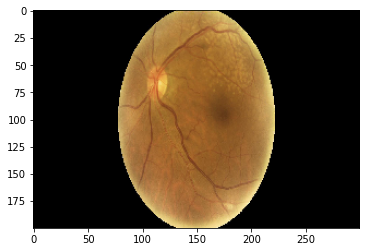

In [ ]:
# for ifile in testlist:
img = tf.keras.preprocessing.image.load_img('/tmp/ODIR-5K/validation/Abnormalities/1031_left.jpg', target_size=target_size,)
# img = tf.keras.preprocessing.image.load_img('/tmp/ODIR-5K/training/Diabetes/1022_left.jpg', target_size=target_size,)
imgplot = plt.imshow(img)
imgarray = tf.keras.preprocessing.image.img_to_array(img)
imgarray = np.expand_dims(imgarray, axis=0)

images = np.vstack([imgarray])
classes = model.predict(images)
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
classes = probability_model.predict(images)
print("file : ", testing_path+testlist[300])
print("predicted as : ", np.argmax(classes))

In [ ]:
predictfun = model.make_predict_function

model.predict(images)

array([[0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [ ]:
testlist = os.listdir(testing_path)

for ifile in testlist:
  img = tf.keras.preprocessing.image.load_img(testing_path+ifile, target_size=target_size,)
  # imgplot = plt.imshow(img)
  imgarray = tf.keras.preprocessing.image.img_to_array(img)
  imgarray = np.expand_dims(imgarray, axis=0)

  images = np.vstack([imgarray])
  classes = model.predict(images, batch_size=8)
  # probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
  # classes = probability_model.predict(images,batch_size=10)
  print("file :", testing_path+ifile," | predicted as :", getkey_indices(np.argmax(classes)), "at :", np.argmax(classes), " | x", np.argmax((model.predict(images) > 0.05).astype("int32")))
  # print("predicted as : ", classes)

file : /tmp/ODIR-5K/testing/2028_left.jpg  | predicted as : Myopia at : 6  | x 6
file : /tmp/ODIR-5K/testing/3482_left.jpg  | predicted as : Normal at : 7  | x 7
file : /tmp/ODIR-5K/testing/1517_left.jpg  | predicted as : Cataract at : 2  | x 2
file : /tmp/ODIR-5K/testing/2260_right.jpg  | predicted as : Myopia at : 6  | x 6
file : /tmp/ODIR-5K/testing/3517_right.jpg  | predicted as : Myopia at : 6  | x 6
file : /tmp/ODIR-5K/testing/1723_right.jpg  | predicted as : Myopia at : 6  | x 6
file : /tmp/ODIR-5K/testing/3569_left.jpg  | predicted as : Cataract at : 2  | x 2
file : /tmp/ODIR-5K/testing/4746_right.jpg  | predicted as : Myopia at : 6  | x 6
file : /tmp/ODIR-5K/testing/4748_left.jpg  | predicted as : Myopia at : 6  | x 6
file : /tmp/ODIR-5K/testing/1348_right.jpg  | predicted as : Abnormalities at : 1  | x 1
file : /tmp/ODIR-5K/testing/1300_left.jpg  | predicted as : Diabetes at : 3  | x 3
file : /tmp/ODIR-5K/testing/4711_right.jpg  | predicted as : Myopia at : 6  | x 6
file : /t

KeyboardInterrupt: ignored

In [ ]:
test_dir = '/tmp/ODIR-5K/testing/'

print(len(os.listdir(testing_path)))

# test_datagen = ImageDataGenerator(rescale=1./255)

# test_generator = test_datagen.flow_from_directory(
#         test_dir,
#         target_size=target_size,
#         color_mode="rgb",
#         shuffle = False,
#         class_mode='categorical',
#         batch_size=1)

# filenames = test_generator.filenames
# nb_samples = len(filenames)

# predict = model.predict_generator(test_generator)
# np.argmax(predict[0])
# for i in range (500):
#   print(np.argmax(predict[i]))

In [ ]:
# Evaluate the model on the test dataset
evaluation_results = model.evaluate(test_generator)
print("Evaluation results:", evaluation_results)

# Generate predictions
predictions = model.predict(test_generator)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Define the number of images you want to display
num_images_to_display = 9

# Initialize lists to store the images and labels
display_images = []
display_labels = []

# Iterate over the dataset to collect images and labels
for images, labels in test_ds.unbatch().take(num_images_to_display):
    display_images.append(images)
    display_labels.append(labels)

# Now plot the images with predictions and true labels
plt.figure(figsize=(10, 10))
for i, image in enumerate(display_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    true_label = class_labels[np.argmax(display_labels[i].numpy())]
    predicted_label = class_labels[predicted_classes[i]]
    plt.title(f"Predicted: {predicted_label}\nTrue: {true_label}")
    plt.axis("off")
plt.show()

# Further Evaluation Metrics

In [ ]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score

##Classification Report

In [ ]:
for _, label in test_generator.unbatch().take(1):
    print("Unbatched label shape:", label.numpy().shape)
# Collect the true labels from the unbatched dataset
true_labels = np.vstack([y.numpy() for _, y in test_generator.unbatch()])

# true_labels should now be a 2-dimensional array, you can verify by printing its shape
print("Shape of true_labels after vstack:", true_labels.shape)

# Convert one-hot encoded labels to class indices
true_classes = np.argmax(true_labels, axis=1)

In [ ]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Now, the number of predicted classes should match the number of true classes
# Generate the classification report again
report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)

print(report)

##Balanced Accuracy Score



In [ ]:
balanced_accuracy = balanced_accuracy_score(true_classes, predicted_classes)
print('Balanced Accuracy: {:.4f}'.format(balanced_accuracy))

##Area Under the Reciever Operating Characteristic Curve (AUC-ROC)

In [ ]:
from keras.utils import to_categorical
true_classes_one_hot = to_categorical(true_classes, num_classes=8)

# Calculate ROC AUC for multi-class classification
roc_auc = roc_auc_score(true_classes_one_hot, predictions, average='macro', multi_class='ovo')

print(f'ROC AUC: {roc_auc:.4f}')

##Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()